In [1]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [2]:
def fetch_data(ticker, start_date, end_date):
    """
    Fetch daily stock price data and filter it to include data only up to the last day of the previous month.

    Parameters:
    ticker (str): Stock ticker symbol
    start_date (str): Start date for data retrieval in 'YYYY-MM-DD' format
    end_date (str): End date for data retrieval in 'YYYY-MM-DD' format

    Returns:
    stock_data (pandas.DataFrame): Historical price data including 'Prices' only
    stock_data_last (pandas.DataFrame): Filtered data up to the last day of the previous month
    """

    # Download the daily price data
    # Select the 'Close' column, rename it to 'Prices', and set the index name
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
    stock_data = stock_data[['Close']].copy()
    stock_data.rename(columns={'Close': 'Prices'}, inplace=True)
    stock_data.index.name = 'Dates'

    # Calculate the last day of the previous month
    last_day_previous_month = pd.Timestamp.now().normalize() - pd.offsets.MonthBegin(12)
    # Filter data to include only dates up to the last day of the previous month
    stock_data_last = stock_data[stock_data.index.tz_localize(None) < last_day_previous_month]

    # Will be used in future updates for price comparison
    stock_daily = yf.download(ticker, start=start_date, end=end_date)
    stock_daily = stock_daily[['Close']].copy()
    stock_daily.index.name = 'Dates'

    return stock_daily, stock_data_last


def forecast_until_date(future_date, signals):
    """
    Forecast future prices using the Holt-Winters Exponential Smoothing method.

    Parameters:
    future_date (str): The date until which to forecast, formatted as 'YYYY-MM-DD'
    signals (pd.DataFrame): Historical close prices, indexed by date

    Returns:
    forecast_df (pandas.DataFrame): DataFrame with forecasted dates and prices
    """
    
    # Initialize the Holt-Winters model with additive trend and seasonal components
    # Setting seasonal_periods to 12 for monthly seasonality
    model = ExponentialSmoothing(signals['Prices'], trend='add', seasonal='add', seasonal_periods=12)

    # Fit the model to the historical data
    fitted_model = model.fit()

    # Calculate the number of months between the last known data point and the future date
    last_date = signals.index[-1]
    future_date = pd.to_datetime(future_date)

    forecast_periods = (
        (future_date.year - last_date.year) * 12
        + (future_date.month - last_date.month)
    )

    # Generate the date index for the forecast period with monthly frequency
    forecast_index = pd.date_range(last_date, periods=forecast_periods + 1, freq='ME')[1:]

    # Generate the forecast for the calculated number of periods
    forecast = fitted_model.forecast(steps=forecast_periods)

    # Combine the forecast values and dates into a DataFrame
    forecast_df = pd.DataFrame({'Forecast': forecast.values}, index=forecast_index)

    return forecast_df


def estimate_price(target_date, signals):
    """
    Estimate the price for a specific future date based on the monthly forecast.

    Parameters:
    target_date (str): The target date for price estimation, formatted as 'YYYY-MM-DD'
    signals (pd.DataFrame): Historical close prices, indexed by date

    Returns:
    float: The estimated price on the target date
    """
    # Convert the target date to a datetime object
    target_date = pd.to_datetime(target_date)

    # Ensure the DataFrame is sorted by date
    signals = signals.sort_index()

    # Iterate over the DataFrame rows by index positions
    for i in range(1, len(signals)):  # Start from 1 to access the previous row
        # Access rows using .iloc
        prev_row = signals.iloc[i - 1]
        curr_row = signals.iloc[i]

        # Compare the target date with the current row's date
        if target_date < curr_row.name:  # .name gives the index of the current row
            # Calculate the number of days between the two dates
            num_dates = (curr_row.name - prev_row.name).days
            
            # Calculate the slope between the two prices
            slope = (curr_row["Forecast"] - prev_row["Forecast"]) / num_dates
            
            # Estimate the price at the target date
            days_to_target = (target_date - prev_row.name).days
            target_price = prev_row["Forecast"] + slope * days_to_target
            return target_price

    # If the target date is beyond the last date in signals, return the last known price
    return signals.iloc[-1]["Forecast"]


def plot_forecast(
    ticker, signals, signals_last, forecast, target_date=None, target_price=None
):
    """
    Plot historical prices along with forecasted prices and highlight the target date.

    Parameters:
    ticker (str): The stock ticker symbol
    signals (pd.DataFrame): Historical prices with date index
    signals_last (pd.DataFrame): Data containing signals but excluding recent months
    forecast (pd.DataFrame): DataFrame with forecasted prices, indexed by dates
    target_date (datetime, optional): Specific date to highlight in the plot
    target_price (float, optional): Estimated price for the target date
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot historical signals
    ax1.plot(signals.index, signals['Close'], label='Historical Daily Prices', color='blue')
    ax1.set_title("Historical Daily Close Prices")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    ax1.legend()

    # Plot forecast prices in the second axis
    ax2.plot(signals_last.index, signals_last['Prices'], label='Historical Monthly Prices', color='blue')
    ax2.plot(forecast.index, forecast['Forecast'], label='Forecasted Prices', color='green', linestyle='--')

    # Plot everything else but the signals (e.g., target date and price)
    if target_date is not None and target_price is not None:
        ax2.scatter(
            target_date,
            target_price,
            color='orange',
            marker='o',
            label=f'Estimated Price on {target_date.strftime("%Y-%m-%d")}',
        )
        ax2.axvline(target_date, color='red', linestyle=':', alpha=0.7)

    # You can add more elements here as needed
    ax2.set_title("Forecasted Prices and Highlights")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.grid(True)
    ax2.legend()

    plt.suptitle(f"{ticker} Price Forecast and Comparisons")
    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: Fu

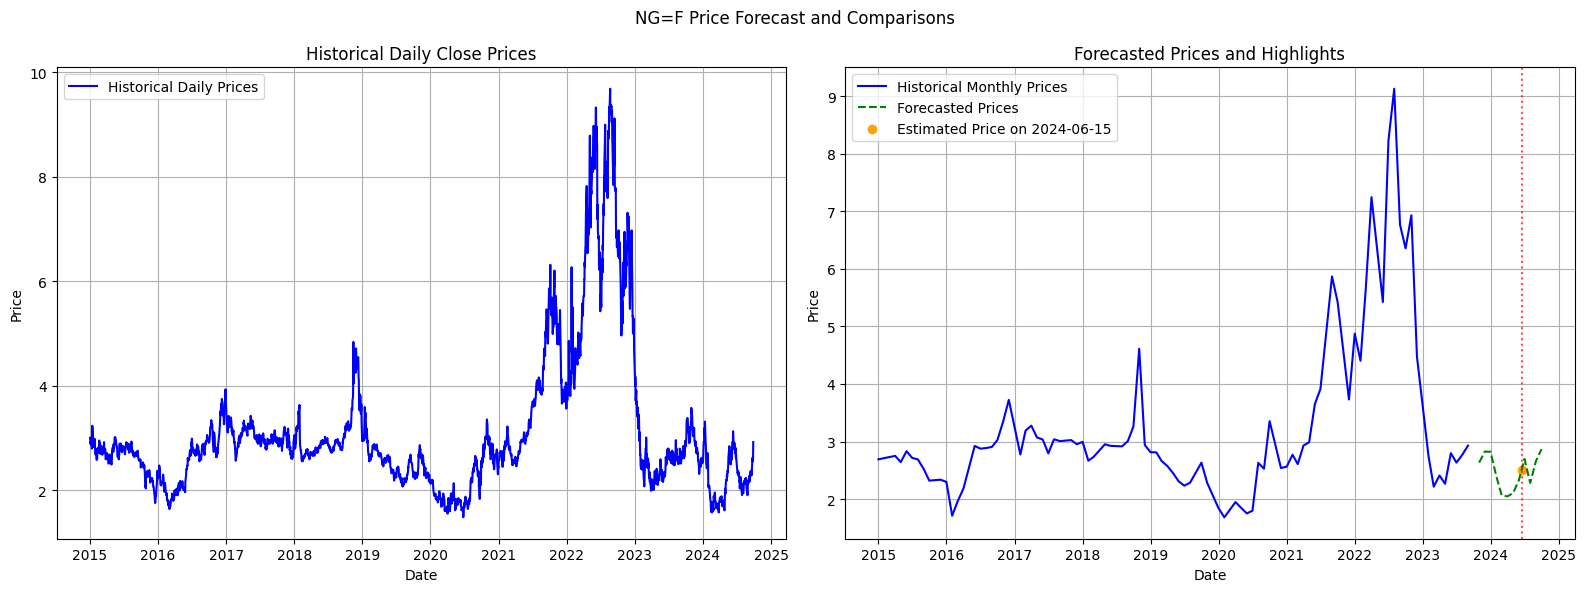

Estimated price on 2024-06-15: 2.51


In [3]:

# Example usage
ticker = "NG=F"
start_date = "2015-01-01"
end_date = pd.to_datetime('today').normalize()

# Fetch stock data
data, data_last = fetch_data(ticker, start_date, end_date)

# Example: Forecast until a specific future date
forecast_date = end_date
target_date = "2024-06-15"  # Can use any date, linear fit will adjust

# Forecast prices until the specified forecast date
forecast = forecast_until_date(forecast_date, data_last)

# Estimate the price on the specified target date using daily interpolation
estimated_price = estimate_price(target_date, forecast)

# Plot historical prices and forecast with the estimated target price highlighted
plot_forecast(
    ticker,
    data,
    data_last,
    forecast,
    target_date=pd.to_datetime(target_date),
    target_price=estimated_price
)

# Print the estimated price for the specified future date
print(f"Estimated price on {target_date}: {estimated_price:.2f}")